- Разбор самостоятельной: фундаментальное ограничение МО, ROC AUC
- Домашка, решение с `scikit-learn`
- Этот блокнот
- Экзамен

# About

In this programming assignment you will train a classifier to identify type of a particle. There are six particle types: electron, proton, muon, kaon, pion and ghost. Ghost is a particle with other type than the first five or a detector noise. 

Different particle types remain different responses in the detector systems or subdetectors. Thre are five systems: tracking system, ring imaging Cherenkov detector (RICH), electromagnetic and hadron calorimeters, and muon system.

![pid](pic/pid.jpg)

You task is to identify a particle type using the responses in the detector systems. 

# Attention

Data files you should download from https://github.com/hse-aml/hadron-collider-machine-learning/releases/tag/Week_2

In [1]:
%matplotlib inline
import os
import requests
import matplotlib.pyplot as plt
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import utils

# Download data

Download data used to train classifiers.

<https://github.com/hse-aml/hadron-collider-machine-learning/releases/download/Week_2/training.csv.gz>

<https://clck.ru/EuWb9>

### Read training file

In [2]:
data = pandas.read_csv('training.csv.gz')
data = data.sample(10**5, replace=True)

In [3]:
data.head()

,TrackP,TrackNDoFSubdetector2,BremDLLbeElectron,MuonLooseFlag,FlagSpd,SpdE,EcalDLLbeElectron,DLLmuon,RICHpFlagElectron,EcalDLLbeMuon,...,TrackNDoF,RICHpFlagMuon,RICH_DLLbeKaon,RICH_DLLbeElectron,HcalE,MuonFlag,FlagMuon,PrsE,RICH_DLLbeMuon,RICH_DLLbeProton
847911,6718.910138,7.0,1.425986,0.0,1.0,3.2,-2.770080,-8.109286,1.0,0.433957,...,24.0,1.0,-16.058778,-5.346579,6413.833486,0.0,1.0,-0.000002,-16.400079,-20.854379
905641,3226.000004,16.0,2.151074,0.0,0.0,-999.0,-999.000000,-6.966829,1.0,-999.000000,...,30.0,1.0,-1.048186,48.570315,-999.000000,0.0,0.0,-999.000000,-10.970185,-0.391686
782465,23396.890633,7.0,-999.000000,0.0,0.0,-999.0,-999.000000,-1.843407,1.0,-999.000000,...,19.0,1.0,-24.254507,-2.361408,-999.000000,0.0,0.0,-999.000000,-1.235708,-19.222807
815254,2223.439945,17.0,-0.016040,0.0,1.0,3.2,-999.000000,-2.623107,1.0,-999.000000,...,31.0,1.0,-0.135616,-1.059616,-999.000000,0.0,0.0,24.958720,-1.151916,-0.000016
628898,7682.290049,16.0,-0.357757,0.0,1.0,3.2,-2.558208,-3.011052,1.0,0.382713,...,31.0,1.0,25.025986,-2.771413,1725.010132,0.0,1.0,5.211163,-4.285213,18.361687


### List of columns in the samples

Here, **Spd** stands for Scintillating Pad Detector, **Prs** - Preshower, **Ecal** - electromagnetic calorimeter, **Hcal** - hadronic calorimeter, **Brem** denotes traces of the particles that were deflected by detector.

- ID - id value for tracks (presents only in the test file for the submitting purposes)
- Label - string valued observable denoting particle types. Can take values "Electron", "Muon", "Kaon", "Proton", "Pion" and "Ghost". This column is absent in the test file.
- FlagSpd - flag (0 or 1), if reconstructed track passes through Spd
- FlagPrs - flag (0 or 1), if reconstructed track passes through Prs
- FlagBrem - flag (0 or 1), if reconstructed track passes through Brem
- FlagEcal - flag (0 or 1), if reconstructed track passes through Ecal
- FlagHcal - flag (0 or 1), if reconstructed track passes through Hcal
- FlagRICH1 - flag (0 or 1), if reconstructed track passes through the first RICH detector
- FlagRICH2 - flag (0 or 1), if reconstructed track passes through the second RICH detector
- FlagMuon - flag (0 or 1), if reconstructed track passes through muon stations (Muon)
- SpdE - energy deposit associated to the track in the Spd
- PrsE - energy deposit associated to the track in the Prs
- EcalE - energy deposit associated to the track in the Hcal
- HcalE - energy deposit associated to the track in the Hcal
- PrsDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Prs
- BremDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Brem
- TrackP - particle momentum
- TrackPt - particle transverse momentum
- TrackNDoFSubdetector1  - number of degrees of freedom for track fit using hits in the tracking sub-detector1
- TrackQualitySubdetector1 - chi2 quality of the track fit using hits in the tracking sub-detector1
- TrackNDoFSubdetector2 - number of degrees of freedom for track fit using hits in the tracking sub-detector2
- TrackQualitySubdetector2 - chi2 quality of the track fit using hits in the  tracking sub-detector2
- TrackNDoF - number of degrees of freedom for track fit using hits in all tracking sub-detectors
- TrackQualityPerNDoF - chi2 quality of the track fit per degree of freedom
- TrackDistanceToZ - distance between track and z-axis (beam axis)
- Calo2dFitQuality - quality of the 2d fit of the clusters in the calorimeter 
- Calo3dFitQuality - quality of the 3d fit in the calorimeter with assumption that particle was electron
- EcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Ecal
- EcalDLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from Ecal
- EcalShowerLongitudinalParameter - longitudinal parameter of Ecal shower
- HcalDLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from Hcal
- HcalDLLbeMuon - delta log-likelihood for a particle candidate to be using information from Hcal
- RICHpFlagElectron - flag (0 or 1) if momentum is greater than threshold for electrons to produce Cherenkov light
- RICHpFlagProton - flag (0 or 1) if momentum is greater than threshold for protons to produce Cherenkov light
- RICHpFlagPion - flag (0 or 1) if momentum is greater than threshold for pions to produce Cherenkov light
- RICHpFlagKaon - flag (0 or 1) if momentum is greater than threshold for kaons to produce Cherenkov light
- RICHpFlagMuon - flag (0 or 1) if momentum is greater than threshold for muons to produce Cherenkov light
- RICH_DLLbeBCK  - delta log-likelihood for a particle candidate to be background using information from RICH
- RICH_DLLbeKaon - delta log-likelihood for a particle candidate to be kaon using information from RICH
- RICH_DLLbeElectron - delta log-likelihood for a particle candidate to be electron using information from RICH
- RICH_DLLbeMuon - delta log-likelihood for a particle candidate to be muon using information from RICH
- RICH_DLLbeProton - delta log-likelihood for a particle candidate to be proton using information from RICH
- MuonFlag - muon flag (is this track muon) which is determined from muon stations
- MuonLooseFlag muon flag (is this track muon) which is determined from muon stations using looser criteria
- MuonLLbeBCK - log-likelihood for a particle candidate to be not muon using information from muon stations
- MuonLLbeMuon - log-likelihood for a particle candidate to be muon using information from muon stations
- DLLelectron - delta log-likelihood for a particle candidate to be electron using information from all subdetectors
- DLLmuon - delta log-likelihood for a particle candidate to be muon using information from all subdetectors
- DLLkaon - delta log-likelihood for a particle candidate to be kaon using information from all subdetectors
- DLLproton - delta log-likelihood for a particle candidate to be proton using information from all subdetectors
- GhostProbability - probability for a particle candidate to be ghost track. This variable is an output of classification model used in the tracking algorithm.

Delta log-likelihood in the features descriptions means the difference between log-likelihood for the mass hypothesis that a given track is left by some particle (for example, electron) and log-likelihood for the mass hypothesis that a given track is left by a pion (so, DLLpion = 0 and thus we don't have these columns). This is done since most tracks (~80%) are left by pions and in practice we actually need to discriminate other particles from pions. In other words, the null hypothesis is that particle is a pion.

### Look at the labels set

The training data contains six classes. Each class corresponds to a particle type. Your task is to predict type of a particle.

In [4]:
set(data.Label)

{'Electron', 'Ghost', 'Kaon', 'Muon', 'Pion', 'Proton'}

Convert the particle types into class numbers.

In [5]:
data['Class'] = utils.get_class_ids(data.Label)
set(data.Class)

{0, 1, 2, 3, 4, 5}

### Define training features

The following set of features describe particle responses in the detector systems:

![features](pic/features.jpeg)

Also there are several combined features. The full list is following.

In [6]:
features = list(set(data.columns) - {'Label', 'Class'})
features

['TrackQualityPerNDoF',
 'MuonLLbeBCK',
 'FlagHcal',
 'TrackQualitySubdetector2',
 'TrackNDoF',
 'PrsDLLbeElectron',
 'RICHpFlagPion',
 'DLLmuon',
 'RICH_DLLbeBCK',
 'HcalDLLbeMuon',
 'EcalE',
 'MuonFlag',
 'RICHpFlagMuon',
 'HcalDLLbeElectron',
 'FlagMuon',
 'FlagSpd',
 'RICHpFlagElectron',
 'Calo3dFitQuality',
 'PrsE',
 'HcalE',
 'TrackP',
 'MuonLLbeMuon',
 'MuonLooseFlag',
 'RICH_DLLbeKaon',
 'Calo2dFitQuality',
 'BremDLLbeElectron',
 'TrackDistanceToZ',
 'RICH_DLLbeProton',
 'EcalDLLbeElectron',
 'DLLelectron',
 'FlagEcal',
 'TrackQualitySubdetector1',
 'TrackPt',
 'DLLkaon',
 'GhostProbability',
 'EcalShowerLongitudinalParameter',
 'FlagPrs',
 'FlagRICH1',
 'FlagBrem',
 'RICHpFlagProton',
 'TrackNDoFSubdetector2',
 'RICHpFlagKaon',
 'EcalDLLbeMuon',
 'DLLproton',
 'FlagRICH2',
 'SpdE',
 'RICH_DLLbeMuon',
 'RICH_DLLbeElectron',
 'TrackNDoFSubdetector1']

### Divide training data into 2 parts

In [7]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.90)

/usr/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
len(training_data), len(validation_data)

(90000, 10000)

# Sklearn classifier

On this step your task is to train **Sklearn** classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can.

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
%%time 
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, subsample=0.3, random_state=13,
                                min_samples_leaf=100, max_depth=3,)
gb.fit(training_data[features], training_data.Class)

### Log loss on the cross validation sample

In [ ]:
# predict each track
proba_gb = gb.predict_proba(validation_data[features].values)

In [ ]:
log_loss(validation_data.Class.values, proba_gb)

# Keras neural network

On this step your task is to train **Keras** NN classifier to provide lower **log loss** value.


TASK: your task is to tune the classifier parameters to achieve the lowest **log loss** value on the validation sample you can. Data preprocessing may help you to improve your score.

In [ ]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils

In [ ]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim))
    model.add(Activation('tanh'))

    model.add(Dense(6))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam())
    return model

In [ ]:
nn = nn_model(len(features))
history = nn.fit(
    training_data[features].values,
    np_utils.to_categorical(training_data.Class.values),
    validation_data=(validation_data[features].values,
                     np_utils.to_categorical(validation_data.Class.values)),
    verbose=1,
    nb_epoch=100,
    batch_size=256  
)

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.grid()
plt.legend()

### Log loss on the cross validation sample

In [ ]:
# predict each track
proba_nn = nn.predict_proba(validation_data[features].values)

In [ ]:
log_loss(validation_data.Class.values, proba_nn)

# Quality metrics

Plot ROC curves and signal efficiency dependece from particle mometum and transverse momentum values.

In [ ]:
proba = proba_gb

In [ ]:
utils.plot_roc_curves(proba, validation_data.Class.values)

# Дальше мы не смотрели


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


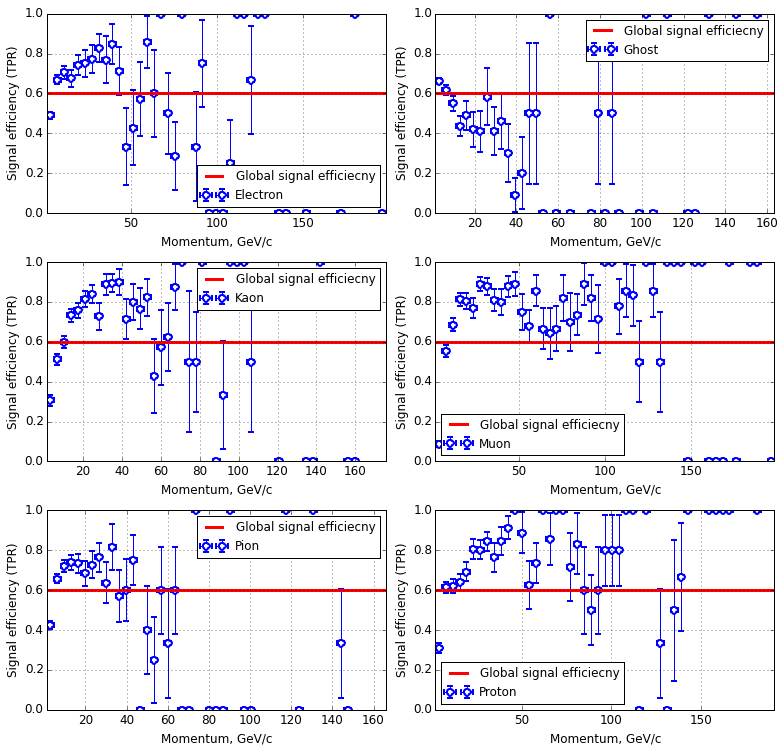

In [21]:
utils.plot_signal_efficiency_on_p(proba, validation_data.Class.values, validation_data.TrackP.values, 60, 50)
plt.show()

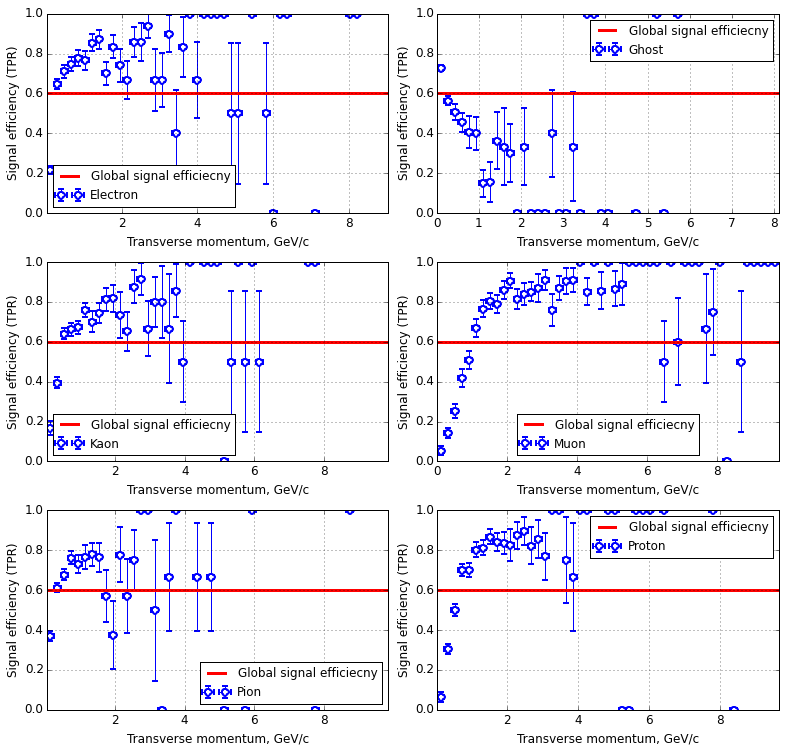

In [22]:
utils.plot_signal_efficiency_on_pt(proba, validation_data.Class.values, validation_data.TrackPt.values, 60, 50)
plt.show()